# Load Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from scipy import stats
import plotly.graph_objects as go
import plotly as px

# Figures formatting
plt.rc('xtick', labelsize=15) 
plt.rc('ytick', labelsize=15) 

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Initialize Spark Session

In [ ]:
! sudo apt install openjdk-8-jdk
! sudo update-alternatives --config java

!apt install libkrb5-dev
!wget https://www-us.apache.org/dist/spark/spark-2.4.5/spark-2.4.5-bin-hadoop2.7.tgz
!tar xf spark-2.4.5-bin-hadoop2.7.tgz
!pip install findspark
!pip install sparkmagic
!pip install pyspark
!pip install pyspark --user
!pip install seaborn --user
!pip install plotly --user
!pip install imageio --user
!pip install folium --user
!apt update
!apt install gcc python-dev libkrb5-dev
from pyspark.sql import SparkSession
from pyspark.sql.types import *
import pyspark.sql.functions as F
import os

spark = SparkSession.builder.appName('ml-hw4').getOrCreate()

%load_ext sparkmagic.magics
#graph section
import networkx as nx
# SQLite RDBMS
import sqlite3
# Parallel processing
# import swifter
import pandas as pd
# NoSQL DB
from pymongo import MongoClient
from pymongo.errors import DuplicateKeyError, OperationFailure
import os
os.environ['SPARK_HOME'] = '/content/spark-2.4.5-bin-hadoop2.7'
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
import pyspark
from pyspark.sql import SQLContext

try:
    if(spark == None):
        spark = SparkSession.builder.appName('Initial').config("spark.driver.memory", "25g").getOrCreate()
        sqlContext=SQLContext(spark)
except NameError:
    spark = SparkSession.builder.appName('Initial').getOrCreate()
    sqlContext=SQLContext(spark)

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  fonts-dejavu-core fonts-dejavu-extra libatk-wrapper-java
  libatk-wrapper-java-jni libxxf86dga1 openjdk-8-jdk-headless openjdk-8-jre
  openjdk-8-jre-headless x11-utils
Suggested packages:
  openjdk-8-demo openjdk-8-source visualvm icedtea-8-plugin libnss-mdns
  fonts-ipafont-gothic fonts-ipafont-mincho fonts-wqy-microhei
  fonts-wqy-zenhei fonts-indic mesa-utils
The following NEW packages will be installed:
  fonts-dejavu-core fonts-dejavu-extra libatk-wrapper-java
  libatk-wrapper-java-jni libxxf86dga1 openjdk-8-jdk openjdk-8-jdk-headless
  openjdk-8-jre openjdk-8-jre-headless x11-utils
0 upgraded, 10 newly installed, 0 to remove and 29 not upgraded.
Need to get 40.7 MB of archives.
After this operation, 153 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 libxxf86dga1 amd64 2:1.1.4-1 [1

# Introduction
This project aims to analyze and predict the performance of Septa trains. SeptaMany people in Philadelphia and surrounding areas depend on Septa to provide reliable transportation services. Septa currently measures their reliability with the metric On Time Performance (OTP). Using this metric, a train is considered on time if it arrives less than 6 minutes late. Septa aims for an OTP of 91% of greater. However, this metric is not particularly useful for commuters who care primarily about the status of the particular train they are taking, not performance across all trains. Therefore, I aim to accurately predict trains' arrival times in order to best inform people's decisions of which trains to take. Further, I hope to identify areas at which train service can be improved to provide an opportunity to increase the reliability of Septa service. 

The dataset was obtained from Kaggle (https://www.kaggle.com/septa/on-time-performance#trainView.csv). The original dataset consists of 13 features detailing attributes such as a train's id, location, next station stop, a timestamp, and more. The primary feature of interst is  status, which is a measure of how many minutes late a train is running.

# Load the Dataset
To load the dataset, I downloaded the associated files from Kaggle as a zip file and placed them into a folder on Gooogle Drive. I then unzipped the file and read in the data as a .csv.

In [ ]:
import os
from google.colab import drive
from google_drive_downloader import GoogleDriveDownloader as gdd

# Mount google drive
DRIVE_MOUNT='/content/gdrive'
drive.mount(DRIVE_MOUNT)

# Create folder to write data to
CIS545_FOLDER=os.path.join(DRIVE_MOUNT, 'My Drive', 'CIS545_2020')
FINAL_PROJECT_FOLDER=os.path.join(CIS545_FOLDER, 'Final_Project')
os.makedirs(FINAL_PROJECT_FOLDER, exist_ok=True)

# Download and unzip
gdd.download_file_from_google_drive(file_id='1A-dYo1ba1mjTrnH6xjzYrg_fO_GxHjvN',
                                    dest_path='/content/gdrive/My Drive/CIS545_2020/Final_Project/on-time-performance.zip')
!unzip "/content/gdrive/My Drive/CIS545_2020/Final_Project/on-time-performance.zip"

# otp_df = pd.read_csv('otp.csv') 
trainview_df = pd.read_csv('trainView.csv') 
trainview_df

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
Archive:  /content/gdrive/My Drive/CIS545_2020/Final_Project/on-time-performance.zip
  inflating: database.sqlite         
  inflating: otp.csv                 
  inflating: trainView.csv           


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning:

Columns (0,1,8) have mixed types.Specify dtype option on import or set low_memory=False.



,train_id,status,next_station,service,dest,lon,lat,source,track_change,track,date,timeStamp0,timeStamp1,seconds
0,102TT,0,Radnor,LOCAL,Colmar-Link Belt,-75.37250,40.04388,Devon,-1,-1,2016-04-22,2016-04-22 13:21:07,2016-04-22 13:22:43,96
1,102TT,0,St. Davids,LOCAL,Colmar-Link Belt,-75.38670,40.04583,Devon,-1,-1,2016-04-22,2016-04-22 13:19:11,2016-04-22 13:21:01,110
2,102TT,0,Strafford,LOCAL,Colmar-Link Belt,-75.42277,40.04722,Devon,-1,-1,2016-04-22,2016-04-22 13:15:04,2016-04-22 13:17:01,117
3,102TT,0,Villanova,LOCAL,Colmar-Link Belt,-75.36040,40.04450,Devon,-1,-1,2016-04-22,2016-04-22 13:22:33,2016-04-22 13:22:33,0
4,102TT,0,Wayne-A,LOCAL,Colmar-Link Belt,-75.40447,40.04961,Devon,-1,-1,2016-04-22,2016-04-22 13:16:32,2016-04-22 13:19:06,154
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3601651,x856,0,Ambler,LOCAL,North Hills,-75.24523,40.17064,Penllyn,-1,-1,2016-06-01,2016-06-01 11:04:06,2016-06-01 11:07:00,174
3601652,x856,0,Ft Washington,LOCAL,North Hills,-75.22512,40.15330,Penllyn,-1,-1,2016-06-01,2016-06-01 11:07:06,2016-06-01 11:10:00,174
3601653,x856,0,North Hills,LOCAL,North Hills,-75.17050,40.11234,Penllyn,-1,-1,2016-06-01,2016-06-01 11:15:06,2016-06-01 11:17:01,115
3601654,x856,0,North Hills,LOCAL,North Hills,-75.18549,40.11867,Penllyn,-1,-1,2016-06-01,2016-06-01 11:13:06,2016-06-01 11:15:00,114


# Data Cleaning




We first need to convert columns into appropriate datatypes. Status has some entries that are "None." I removed these values from the dataset and converted the remaining values into integers. I decided to leave entries that have missing values for other features so as not to limit the number of observations for later analysis.

Additionally, the timestamp associated with each row is read in as a string and needs to be converted to datetime. I decided to drop the date column as that column only contains year, month, and day information whereas the timestamp column contians all of that and hour, minute, and second. This specific information will be useful in assessing if train performance is affected by time of day. I parsed out different pieces of the timestamp including month, day of week, hour, and minute and dropped the original timestamp column from the dataset. I did not include the year because all of the data was collected in 2016. 

A suffix of P in the train_id indicates that another train needed to be sent to complete the original journey. I parsed out train_ids with this suffix as they are likely indicative of a problem along the train's route. I then removed the original train_id column as this feature serves solely as a unique identifier for each train and therefore will not be useful for predictions.

Finally, there are several observations that should be removed from the data. A train status of 999 indicates that a train's service has been suspended, not that the train is 999 minutes late. Because there is no true measure of a train's lateness if service is suspended, I will remove the 699 observations with a status of 999 from the dataset. 

The features in the resulting dataset are as follows:

status -  how late a train is running in minutes 

next_station - the name of the next station the train will arrive at

service - whether the train is running local or express service

dest - the station the train's service ends at

lon - longitude coordinates of the train at the timestamp corresponding to the observation

lat - latitude coordinates of the train at the timestamp corresponding to the observation

source - the station the train's service originates from

seconds - the elapsed time in seconds a train spends at its current station

month - the month during which the observation was recorded

hour - the hour at which the observation was recorded

minute - the minute at which the observation was recorded

problem - whether or not the train's id indicates a problem along the train's route

In [ ]:
trainview_df = trainview_df.drop(trainview_df[trainview_df['status'] == 'None'].index) # drop rows with status of none
trainview_df['status'] = trainview_df['status'].apply(lambda x: int(x))
trainview_df['timeStamp0'] =  pd.to_datetime(trainview_df['timeStamp0'])
trainview_df['month'] =  trainview_df['timeStamp0'].apply(lambda x: x.month)
trainview_df['weekday'] =  trainview_df['timeStamp0'].apply(lambda x: datetime.weekday(x))
trainview_df['hour'] =  trainview_df['timeStamp0'].apply(lambda x: x.hour)
trainview_df['minute'] =  trainview_df['timeStamp0'].apply(lambda x: x.minute)
trainview_df['problem'] = trainview_df['train_id'].apply(lambda x: str(x).endswith('P'))
trainview_df = trainview_df.drop(['date', 'timeStamp0', 'timeStamp1', 'train_id', 'track', 'track_change'], axis = 1)

print(trainview_df.dtypes)

status            int64
next_station     object
service          object
dest             object
lon             float64
lat             float64
source           object
seconds           int64
month             int64
weekday           int64
hour              int64
minute            int64
problem            bool
dtype: object


# Exploratory Data Analysis
Each column now looks to be formatted into an appropriate datatype. Using the describe method, we can see the distribution of status across all trains. On average, trains run 4.7 minutes late witha standard deviation of 2.0 minutes. The median value for minutes late is 2.0. The distribution of scores appears to be right skewed as most trains run approximately on time with few trains running very late. 

In [ ]:
print("Summary:")
print(trainview_df['status'].describe())
print("Median:")
print(np.median(trainview_df['status']))

Summary:
count    3.601655e+06
mean     4.721883e+00
std      2.045092e+01
min      0.000000e+00
25%      0.000000e+00
50%      2.000000e+00
75%      5.000000e+00
max      1.440000e+03
Name: status, dtype: float64
Median:
2.0


We can visualize the distribution of statuses with a histogram.

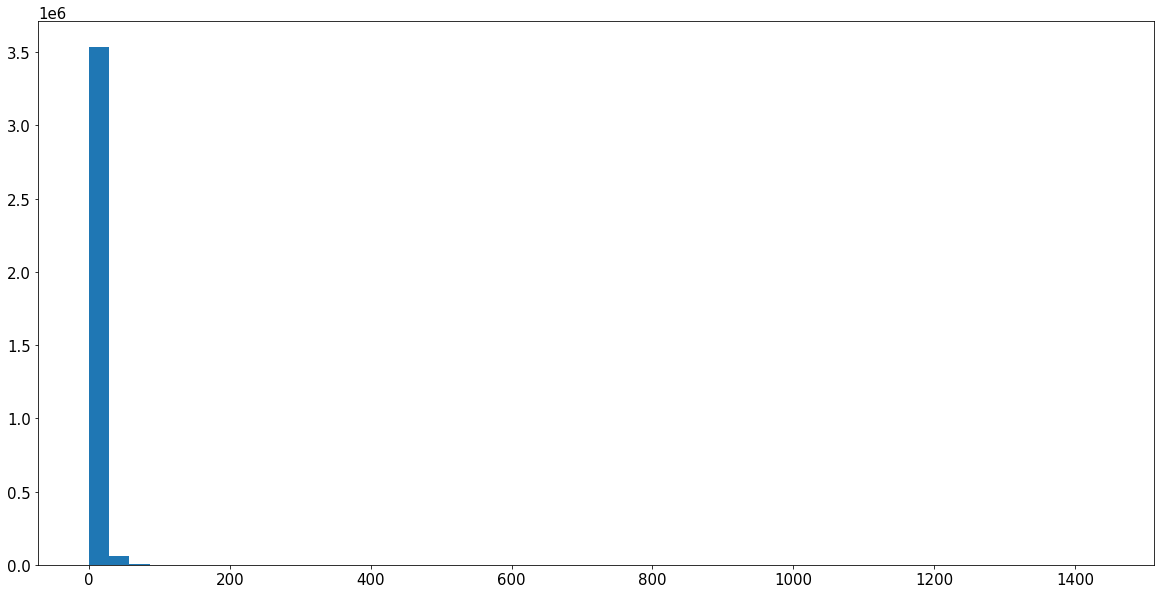

In [ ]:
plt.figure(figsize=(20,10))
plt.hist(x=trainview_df['status'], bins = 50)
plt.show()

Because the vast majority of trains run on time and therefore have a status of 0, it's difficult to visualize the status this way. Using a log transformation, we can see the distribution more clearly. In order to handle zero values with the transformation, I added one to each status. I previously tried different types of transformations but found that a log transformation was most effective in reducing the skewness of the data. I dropped the original status column. As the histogram below shows, the distribution of statuses is still right skewed - nearly all trains run on time or near on time with few trains running very late.

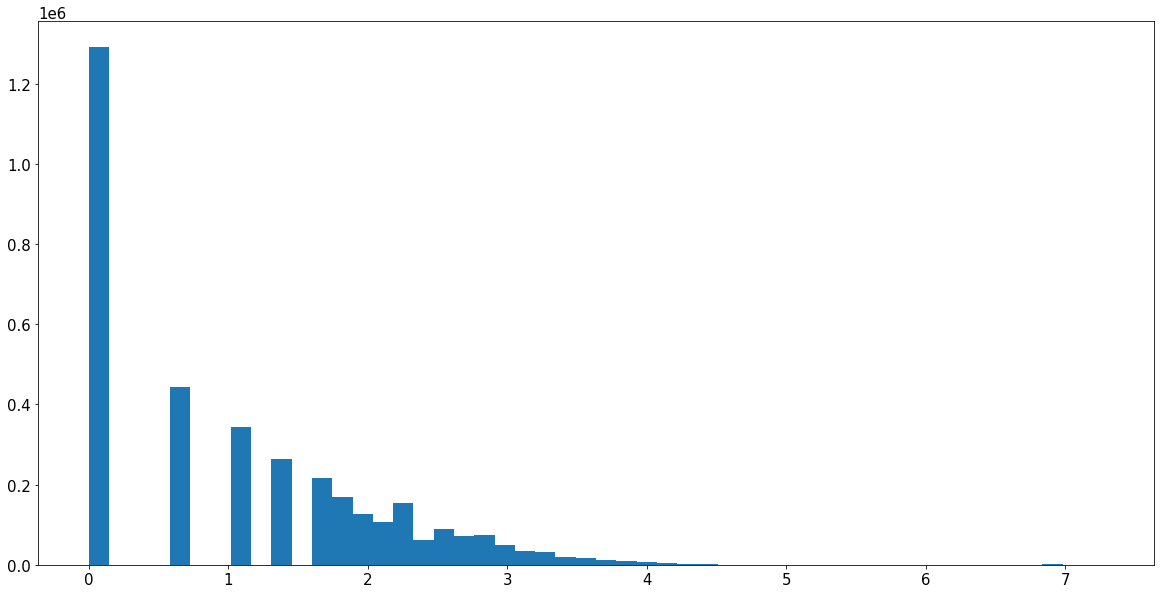

In [ ]:
trainview_df['status_transformed'] = np.log(trainview_df['status']+1)
trainview_df = trainview_df.drop('status', axis = 1)
plt.figure(figsize=(20,10))
plt.hist(x=trainview_df['status_transformed'], bins = 50)
plt.show()

Let's examine some of the variables in the dataset. Looking at the distribution of month, we see that the data was only collected between March and November. Interestingly, there are fewer trains in the summer months (July, August, September) than the other months for which the data was fully collected. Looking at the day of the week, there are more trains that run during the weekdays (0 corresponds to Monday, 1 to Tuesday and so forth) than the weekends. This result intuitively makes sense as trains are likely the busiest when people commute to work during the week. Looking at hour, there appear to be the most trains at peak commuter times around 8 AM and 5 PM and fewer trains very late at night and very early in the morning. Lastly, looking at minute, trains appear to be more or less uniformly distributed across the minutes of the hour.

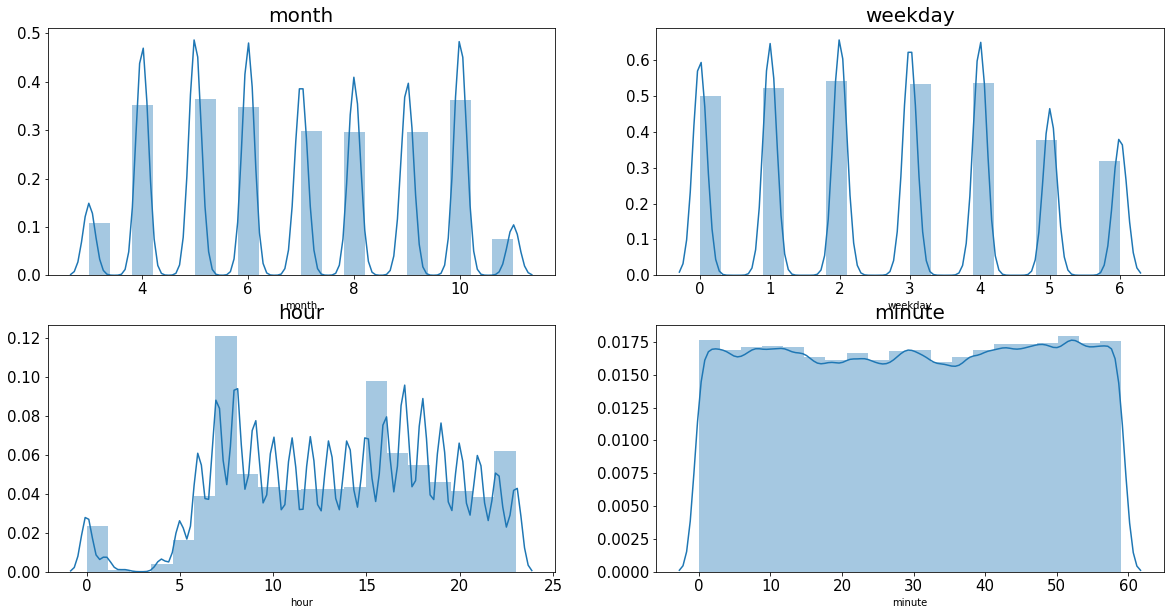

In [ ]:
plt.figure(figsize=(20,10))
fig = 0 
for feature in ['month', 'weekday', 'hour', 'minute']:
  fig += 1
  plt.subplot(2,2,fig)
  sns.distplot(trainview_df[feature], bins=20)
  plt.title(feature, fontsize = 20)
plt.show()



Let's see how the different numeric variables in the dataset are correlated with each other. Looking at the heatmap, it does not appear that any of the variables are strongly correlated with one another. However, month appears to be somewhat correlated with status. 

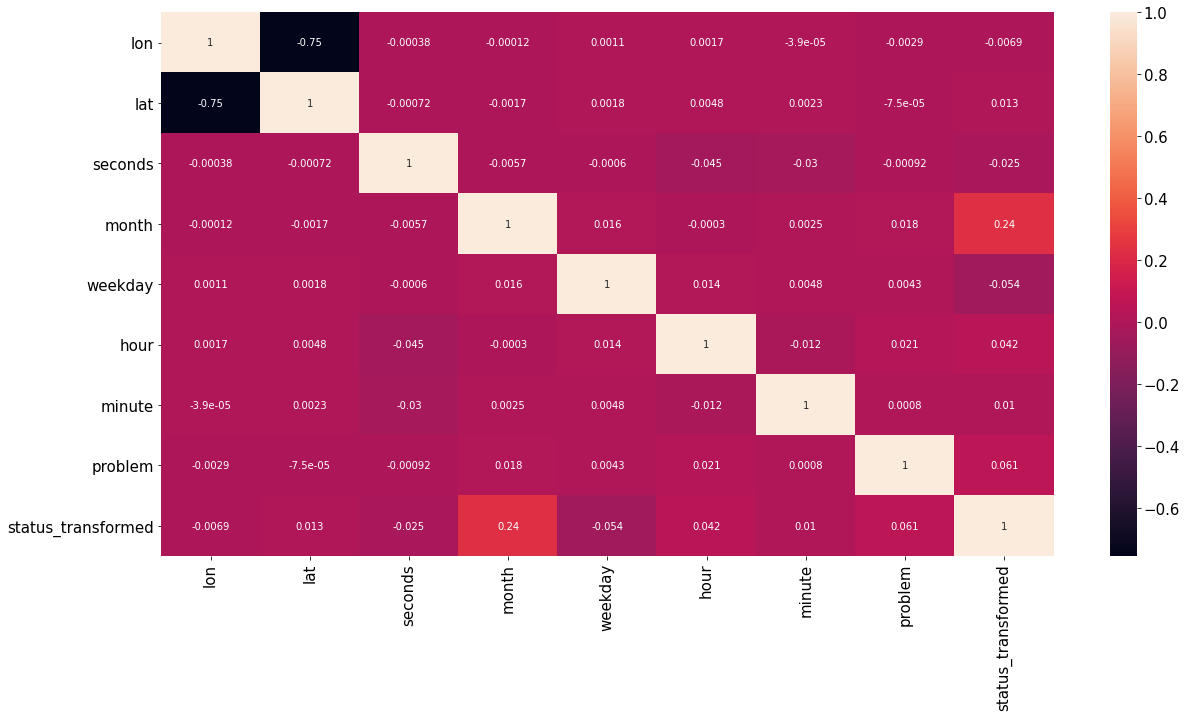

In [ ]:
corrMatrix = trainview_df.corr()
plt.figure(figsize=(20,10))
sns.heatmap(corrMatrix, annot=True)

Next we examine how time impacts train performance in greater detail. All of the times are based off of when a train arrived to a particular location. Note that a higher log status still corresponds to a higher status. I'll continue to use the log transformation of status in order to aid in visualizing trends. First, we look at status by minute. Performance seems to be relatively consistent throughout minutes of the hour. Though there does appear to be several slight fluctutions in status across minutes, no larger trend persists.

Looking at status across the hours each day, trains appear to run later between 8 and 9 AM, which seem to conincide with commuter train times. As I would have expected, it makes sense that trains generally run later during commuter hours when they are likely busiest. Trains also run later around 3 in the morning, which is somewhat surprising, but this result may be strongly affected by the small number of trains that run during the very early hours of the morning. 

Looking at the next boxplot, it does seems that trains run later on average during the weekdays compared to the weekends. This result is expected as I would have expected trains to run later during week days when they are busier as opposed to weekends. Note that 0 corresponds to Monday, 1 to Tuesday and so forth. 

Finally, we look at status by month. The dataset includes data from March to November of 2016 so we are unable to assess performance in January, February, or December of 2016. Based on the months for which there is data available, it appears as though performance is worse in the second half of the year. I would expect performance to be worse in October and November as colder, harsher weather would likely impair some train's technical functions. 

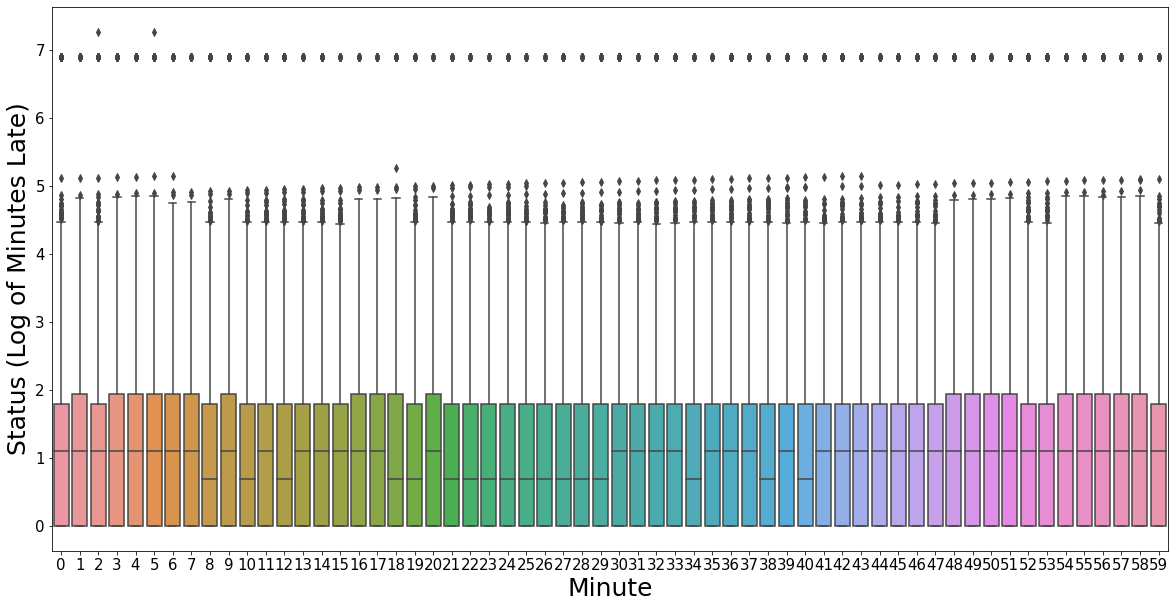

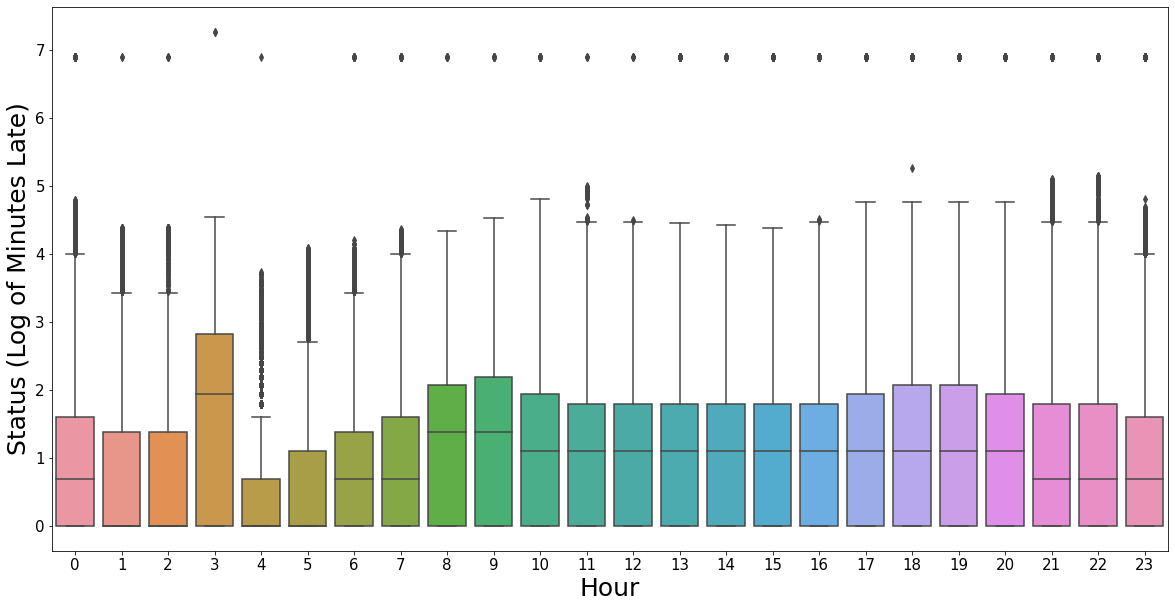

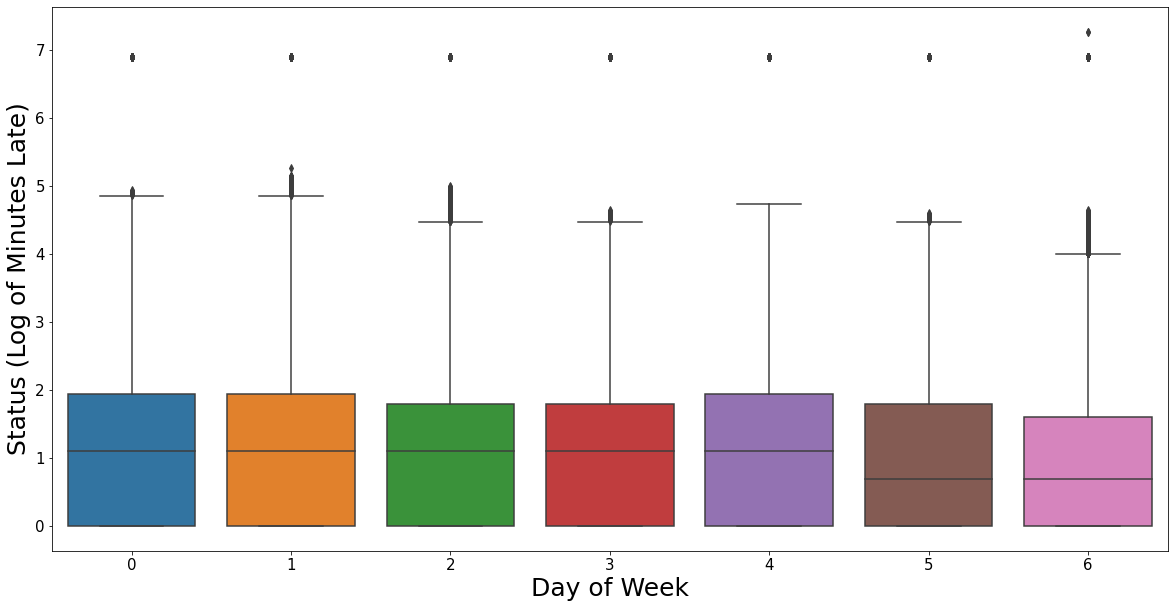

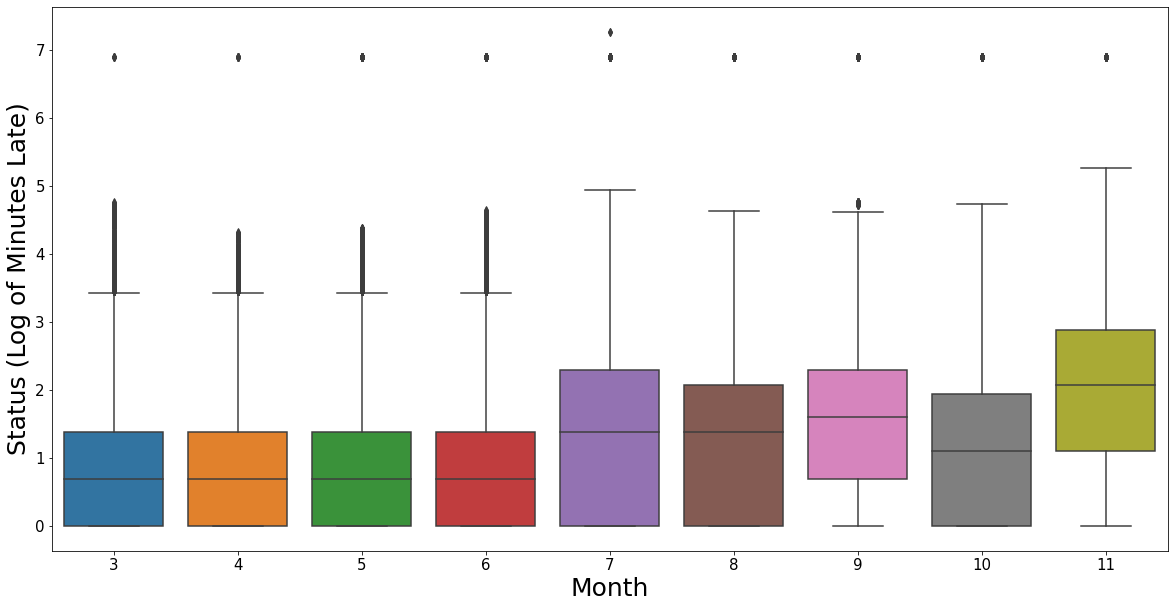

In [ ]:
plt.figure(figsize=(20,10))
sns.boxplot(x = 'minute', y = 'status_transformed', data = trainview_df)
plt.xlabel('Minute', fontsize=25)
plt.ylabel('Status (Log of Minutes Late)', fontsize=25)
plt.show()
plt.figure(figsize=(20,10))
sns.boxplot(x = 'hour', y = 'status_transformed', data = trainview_df)
plt.xlabel('Hour', fontsize=25)
plt.ylabel('Status (Log of Minutes Late)', fontsize=25)
plt.show()
plt.figure(figsize=(20,10))
sns.boxplot(x = 'weekday', y = 'status_transformed', data = trainview_df)
plt.xlabel('Day of Week', fontsize=25)
plt.ylabel('Status (Log of Minutes Late)', fontsize=25)
plt.show()
plt.figure(figsize=(20,10))
sns.boxplot(x = 'month', y = 'status_transformed', data = trainview_df)
plt.xlabel('Month', fontsize=25)
plt.ylabel('Status (Log of Minutes Late)', fontsize=25)
plt.show()

Let's look at how the elapsed time a train spends at a station impacts its performance. There does not seem to be a strong relationship between elapsed time and status based on the scatter plot below.

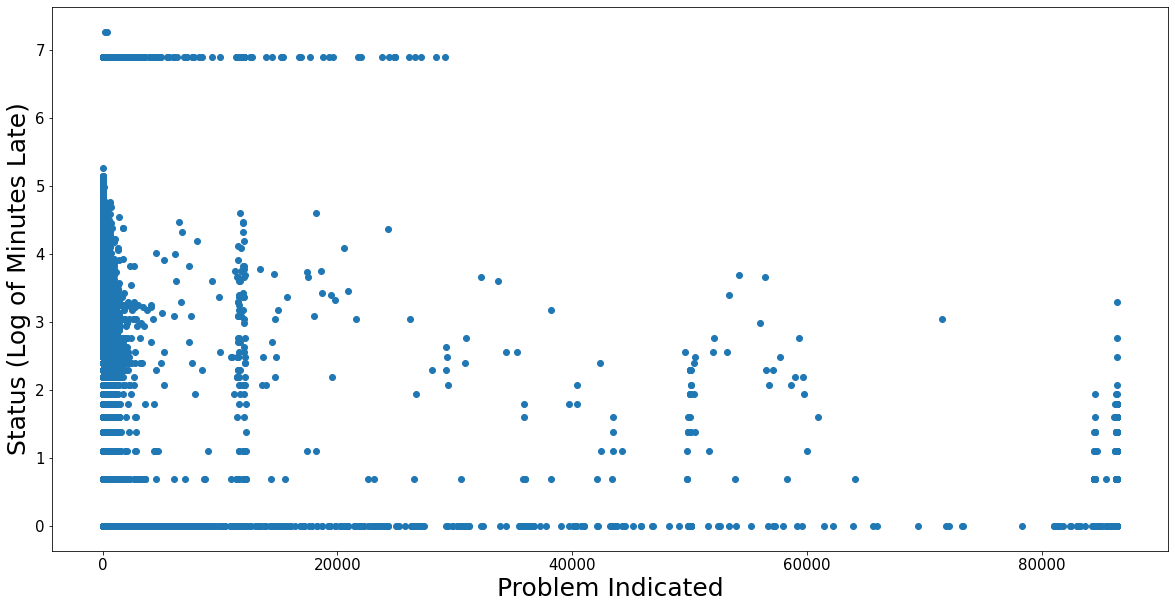

In [ ]:
plt.figure(figsize=(20,10))
plt.scatter(x = 'seconds', y = 'status_transformed', data = trainview_df)
plt.xlabel('Elapsed Time in Seconds', fontsize=25)
plt.ylabel('Status (Log of Minutes Late)', fontsize=25)
plt.show()

Looking at status by if a train's id indicated a problem, we can clearly see that minutes late is higher on average for trains with a problem indicated compared to those without. 

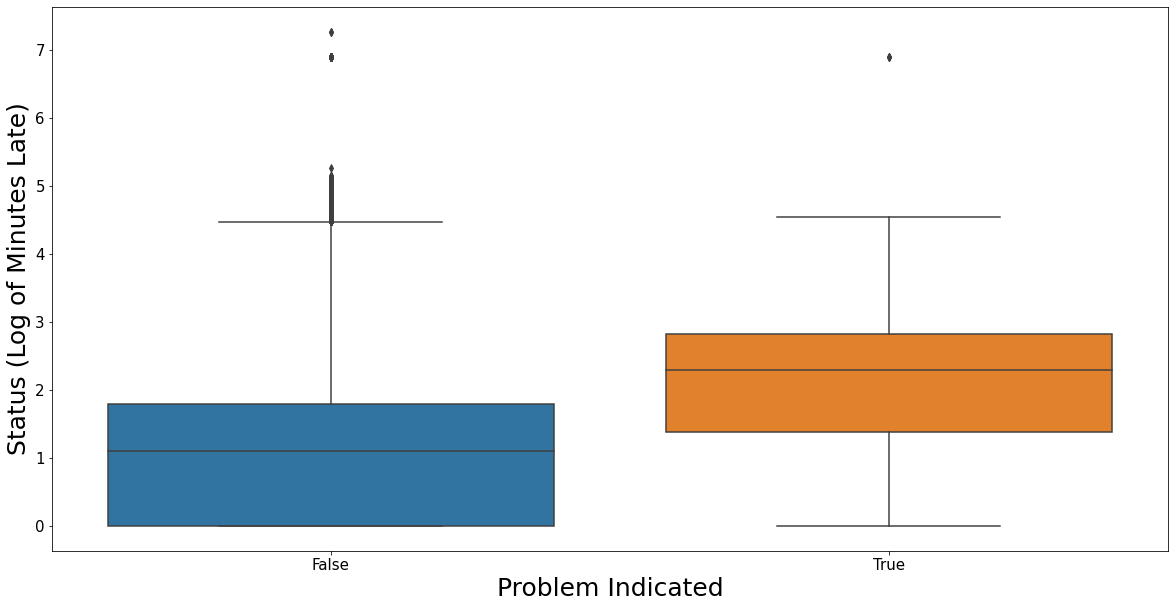

In [ ]:
plt.figure(figsize=(20,10))
sns.boxplot(x = 'problem', y = 'status_transformed', data = trainview_df)
plt.xlabel('Problem Indicated', fontsize=25)
plt.ylabel('Status (Log of Minutes Late)', fontsize=25)
plt.show()

# Preparing Data for Modeling

Before creating models to predict a train's status, several steps needed to be performed. Many machine learning models require data to be numeric rather than categorical. Therefore, I decided to transform the categorical features to numeric ones using a one hot encoding. Doing so drastically increases the number of features in the dataset, which makes the data too large to process in Pandas. To combat this issue, I decided to use Apache Spark for modeling and analysis. First, I copied the data I cleaned in Pandas into a .csv. I then read this data into Spark as shown below.

In [ ]:
trainview_df_copy = trainview_df.copy()
trainview_df_copy = trainview_df_copy.rename(columns = {'status_transformed':'label'}) 
trainview_df_copy.to_csv('trainview_df.csv')
trainview_sdf = spark.read.csv('trainview_df.csv', header = True, inferSchema= True)
trainview_sdf.show()

+---+-------------------+-------+----------------+------------------+------------------+------+-------+-----+-------+----+------+-------+-----+
|_c0|       next_station|service|            dest|               lon|               lat|source|seconds|month|weekday|hour|minute|problem|label|
+---+-------------------+-------+----------------+------------------+------------------+------+-------+-----+-------+----+------+-------+-----+
|  0|             Radnor|  LOCAL|Colmar-Link Belt|          -75.3725|          40.04388| Devon|     96|    4|      4|  13|    21|  false|  0.0|
|  1|         St. Davids|  LOCAL|Colmar-Link Belt|          -75.3867|          40.04583| Devon|    110|    4|      4|  13|    19|  false|  0.0|
|  2|          Strafford|  LOCAL|Colmar-Link Belt|         -75.42277|          40.04722| Devon|    117|    4|      4|  13|    15|  false|  0.0|
|  3|          Villanova|  LOCAL|Colmar-Link Belt|          -75.3604|           40.0445| Devon|      0|    4|      4|  13|    22|  false

Next, I had to encode the categorical features - destination, service, next station, and source - with a one hot encoding using a StringIndexer and a OneHotEncoder. A StringIndexer converts a column of strings to a column of label indices. In using a StringIndexer, columns like "dest," which include the name of the train's destination, became numeric where. For instance, values that were previously "30th St Station" became 5 and values that were previously "Suburban Station" became 7, with the highest number encoded being the number of possible values for that feature. The data all remained in a single column format. This step was necessary because prior to using a one hot encoding in Spark, the features to encode must be numeric. 

Next, I converted these now numeric features using a one hot encoding. A one hot encoding maps a feature to a binary vector of 0's and 1's. Each binary vector contains a single value of 1 which indiates the presence of a specific value of that feature. 

The original columns and string indexed columns for destination, service, and source were dropped, leaving only the one hot encoded versions of these columns. As the portion of the resulting dataframe below shows, the columns for destination, service, next station, and source now consistent of binary vectors.

In [ ]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder

stringIndexer_destination = StringIndexer(inputCol="dest", outputCol="destination_num")
stringIndexer_service = StringIndexer(inputCol="service", outputCol="service_num")
stringIndexer_next_station = StringIndexer(inputCol="next_station", outputCol="next_station_num")
stringIndexer_source = StringIndexer(inputCol="source", outputCol="source_num")

model_destination = stringIndexer_destination.fit(trainview_sdf)
trainview_sdf = model_destination.transform(trainview_sdf)
model_service = stringIndexer_service.fit(trainview_sdf)
trainview_sdf = model_service.transform(trainview_sdf)
model_next_station = stringIndexer_next_station.fit(trainview_sdf)
trainview_sdf = model_next_station.transform(trainview_sdf)
model_source = stringIndexer_source.fit(trainview_sdf)
trainview_sdf = model_source.transform(trainview_sdf)
trainview_sdf = trainview_sdf.drop('dest', 'service', 'next_station', 'source')

encoder_destination = OneHotEncoder(dropLast=False, inputCol="destination_num", outputCol="destination_encoded")
trainview_sdf = encoder_destination.transform(trainview_sdf)
encoder_service = OneHotEncoder(dropLast=False, inputCol="service_num", outputCol="service_encoded")
trainview_sdf = encoder_service.transform(trainview_sdf)
encoder_next_station = OneHotEncoder(dropLast=False, inputCol="next_station_num", outputCol="next_station_encoded")
trainview_sdf = encoder_next_station.transform(trainview_sdf)
encoder_source = OneHotEncoder(dropLast=False, inputCol="source_num", outputCol="source_encoded")
trainview_sdf = encoder_source.transform(trainview_sdf)
trainview_sdf = trainview_sdf.drop('destination_num', 'service_num', 'next_station_num', 'source_num')
trainview_sdf.show()

+---+------------------+------------------+-------+-----+-------+----+------+-------+-----+-------------------+---------------+--------------------+-----------------+
|_c0|               lon|               lat|seconds|month|weekday|hour|minute|problem|label|destination_encoded|service_encoded|next_station_encoded|   source_encoded|
+---+------------------+------------------+-------+-----+-------+----+------+-------+-----+-------------------+---------------+--------------------+-----------------+
|  0|          -75.3725|          40.04388|     96|    4|      4|  13|    21|  false|  0.0|    (59,[19],[1.0])|(103,[0],[1.0])|    (155,[57],[1.0])|(157,[145],[1.0])|
|  1|          -75.3867|          40.04583|    110|    4|      4|  13|    19|  false|  0.0|    (59,[19],[1.0])|(103,[0],[1.0])|    (155,[63],[1.0])|(157,[145],[1.0])|
|  2|         -75.42277|          40.04722|    117|    4|      4|  13|    15|  false|  0.0|    (59,[19],[1.0])|(103,[0],[1.0])|    (155,[59],[1.0])|(157,[145],[1.0])

Next, I used a VectorAssembler to combine all the features to use into a single column of features. This step was necessary as Spark ML models expect input data to be formatted such that all features to use are in a single column, usually named features. The features to be used include longitude, latitude, seconds, month, weekday, hour, minute, problem, and one hot encodings of destinate, service, next station, and source.

The data was then split into a training and testing set with 80% of the data in the training set and 20% of the data reserved for testing. 10% of this training data was reserved for validation so that 72% of the entire dataset was used for training and 8% for validation. I set the random seed to ensure results were reproducible.

In [ ]:
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(inputCols=['lon', 'lat', 'seconds', 'month', 'weekday','hour', 'minute', 'problem', \
                                       'destination_encoded', 'service_encoded', 'next_station_encoded', 'source_encoded'], outputCol='features')

trainview_sdf_transformed = assembler.transform(trainview_sdf)

temp_train_sdf, test_sdf = trainview_sdf_transformed.randomSplit([0.8, 0.2], seed = 1)
train_sdf, validation_sdf = temp_train_sdf.randomSplit([0.9, 0.1], seed = 1)

# Linear Regression
I first decided to train a linear regression model to predict a train's status. The data was scaled using a standard scaler before linear regression. I organized the scaling and regression steps into a pipeline to simplify the process. I trained the model on the training data and then evaluated the model's performance on the test data. The model achieved a root mean squared error of 0.95 (units: log(minutes)) on the testing data. Additionally, the R-squared value between the testing predictions and true testing labels was 0.16.

In [ ]:
from pyspark.ml.feature import StandardScaler, PCA
from pyspark.ml.regression import LinearRegression
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator

scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures")
lr = LinearRegression(featuresCol='scaledFeatures')
pipeline = Pipeline(stages=[scaler, lr])
lr_model = pipeline.fit(train_sdf)
lr_predictions = lr_model.transform(test_sdf)
re = RegressionEvaluator(metricName='rmse')

print("RMSE: " + str(re.evaluate(lr_predictions)))
print("R2: " + str(lr_model.stages[-1].summary.r2))

RMSE: 0.9515216714031397
R2: 0.15983016544551953


The distributions of both the testing predictions and true testing labels are shown below. As the graph indicates, the true labels of train statuses are right skewed. However, the testing predictions follow a roughly normal distribution. 

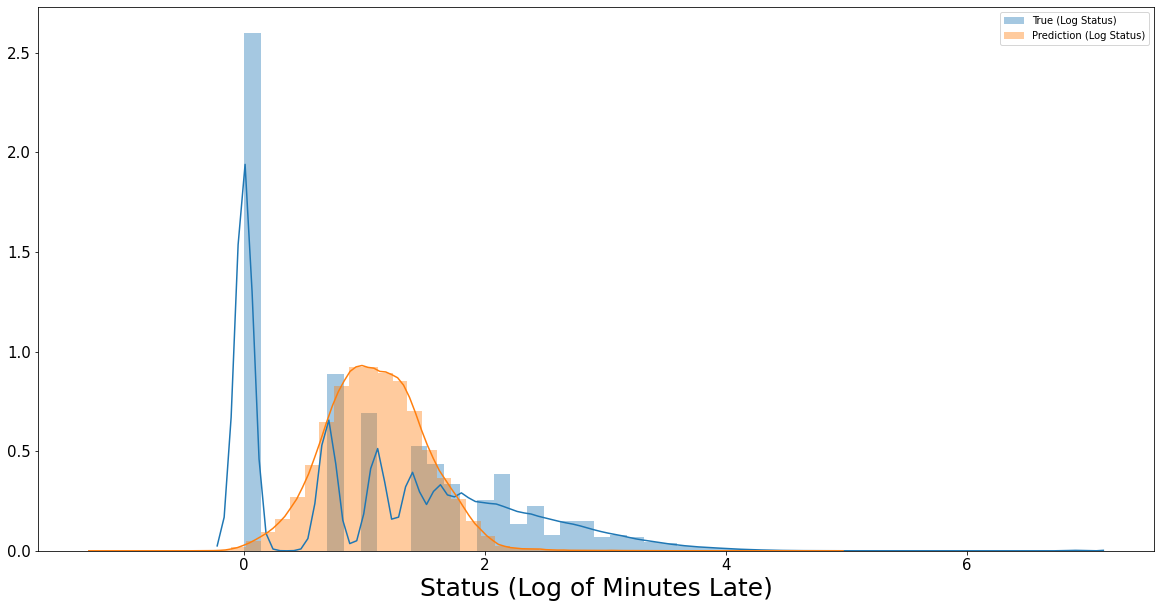

In [ ]:
lr_predictions.createOrReplaceTempView('lr_predictions')
lr_label_pred = spark.sql('SELECT label, prediction FROM lr_predictions').toPandas()
plt.figure(figsize=(20,10))
sns.distplot(lr_label_pred['label'])
sns.distplot(lr_label_pred['prediction'])
plt.xlabel('Status (Log of Minutes Late)', fontsize=25)
ax = plt.gca()
ax.legend(['True (Log Status)', 'Prediction (Log Status)'])
plt.show()

Next, we can look at the coefficients of the linear model. It seems like a majority of the linear model coefficients are small, and several features have coefficients that are more signficant. Because of how many coefficients there are, it is difficult to visualize which features correspond to more signficant coefficients in this way.

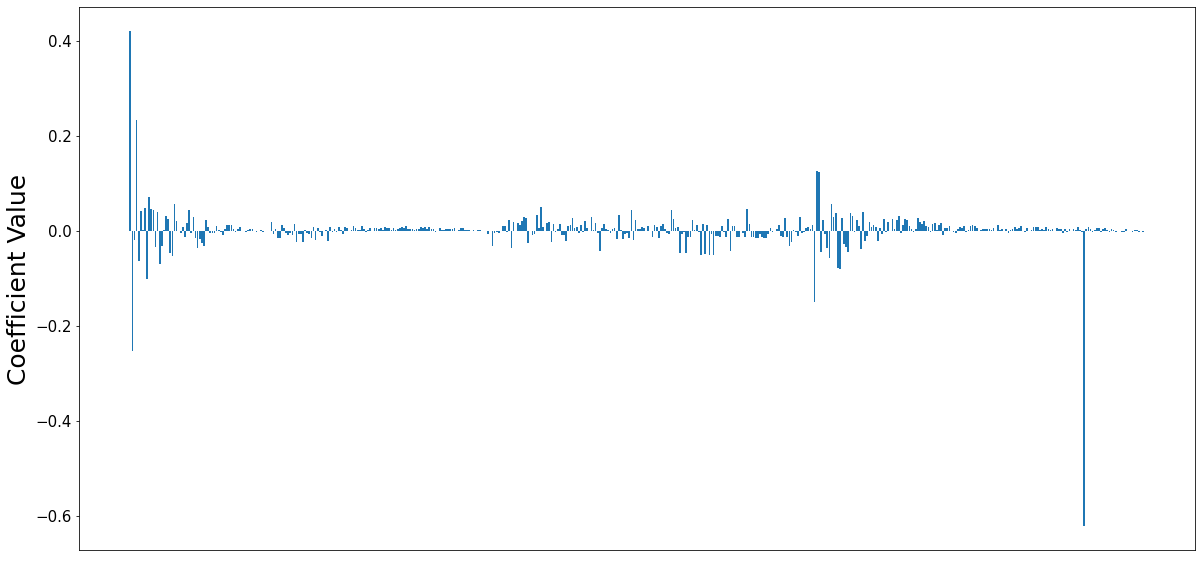

In [ ]:
coeffs = spark.createDataFrame(lr_model.stages[-1].coefficients.values.tolist(), FloatType()).toPandas()
plt.figure(figsize=(20,10))
plt.bar(x=range(0,len(coeffs)), height=coeffs['value'])
plt.ylabel('Coefficient Value', fontsize=25)
ax = plt.gca()
ax.axes.get_xaxis().set_visible(False)

I then decided to determine which features had the most significant coefficients. I needed to extract the features such that they were ordered in the same way as the cofficients. I then looked into features whose coefficients were either greater than 0.1 or less than -0.1. I found which features corresponded to these coefficients and plotted them below. 

As the graph shows, higher longitudes, later months, a source of Doylestown, and a source of West Trenton are positively correlated with status. In other words, a train possessing any of these features is on average more likely to run late than a train that does not possess these features. Conversely, higher latitudes, a destination or source of the airport, and a source of none are negatively correlated with status. In other words, a train possessing any of these features is on average less likely to run late than a train that does not possess these features.
 
Examining these relationships there are several features whose coefficients make sense. A higher month is likely to be correlated with a train running later as months later in the year tend to see colder, harsher weather, which is likely to interfere with train performance. Higher longitude areas correspond to regions around West Philly, and higher latitude areas correspond to regions near Chestnut Hill and Trenton. There could be some way about how the trains and stations in these regions are managed that contributes their optimal or poor performance. It would be interesting to see if other stations, particularly Doylestown and West Trenton where trains generally run late, could adopt the practices of trains leaving from or going to the Airport as these trains seem to run most punctually. 



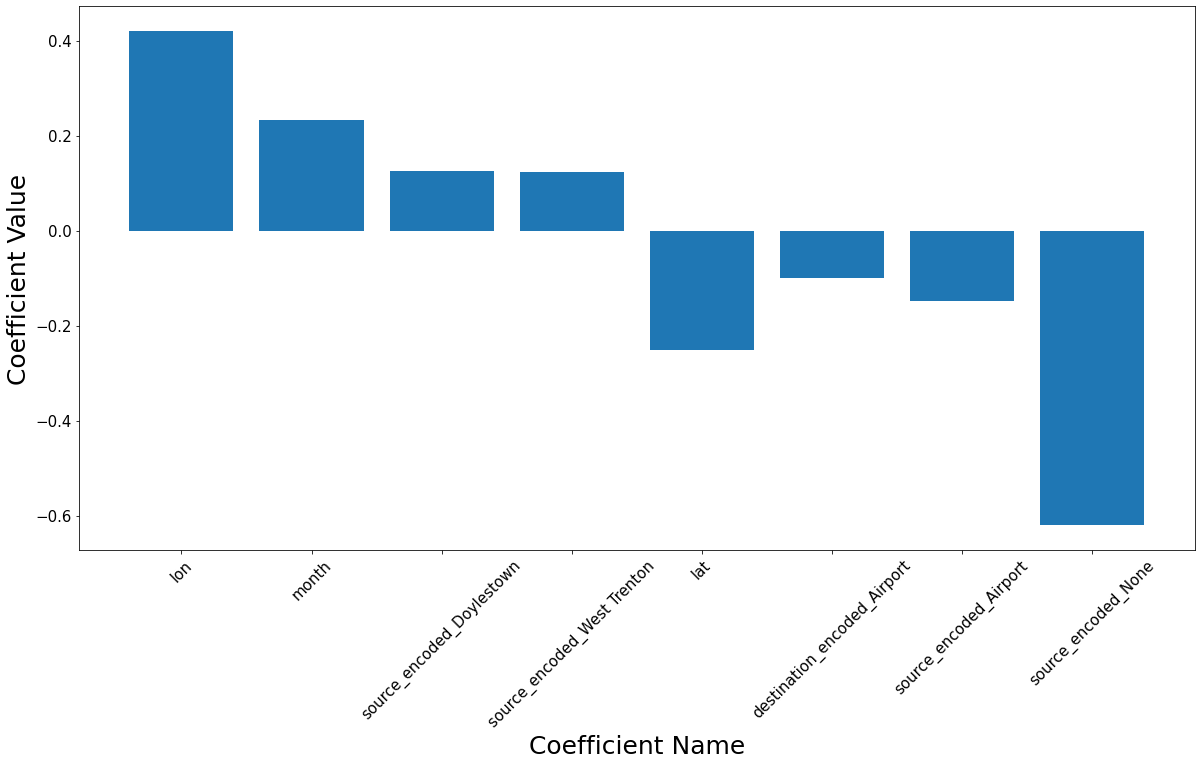

In [ ]:
features = train_sdf.schema["features"].metadata["ml_attr"]["attrs"]

impt_feat_idx = []
for idx in coeffs[coeffs['value']>0.1].index:
  impt_feat_idx.append(idx)
for idx in coeffs[coeffs['value']<-0.1].index:
  impt_feat_idx.append(idx)

impt_feats = {}
for idx in impt_feat_idx:
  val_binary = next((item for item in features['binary'] if item['idx'] == idx), None)
  val_numeric = next((item for item in features['numeric'] if item['idx'] == idx), None)
  if val_binary is not None:
    impt_feats[val_binary['name']] = coeffs.iloc[val_binary['idx']].value
  if val_numeric is not None:
    impt_feats[val_numeric['name']] = coeffs.iloc[val_numeric['idx']].value

plt.figure(figsize=(20,10))
plt.bar(x=impt_feats.keys(), height=impt_feats.values())
plt.xlabel('Coefficient Name', fontsize=25)
plt.ylabel('Coefficient Value', fontsize=25)
plt.xticks(rotation=45)
plt.show()


The high number of parameters whose coefficients are near zero motivates a linear regression model with a Lasso (L1) penalty as there are only a small number of important features. We can try several values for the elastic net parameter, which governs this penalty and evaluate which value of the parameter produces the lowest mean square error on the validation set to select the optimal value for this parameter. Note that the linear regression performed above is equivalent to an elastic net parameter of 0. In additional to this linear regression model, I ran three regularized linear regression models with elastic net parameters of 0.1, 0.5, and 1. All of the models perform nearly identically, likely because the linear regression model does not fit the distribution of the data. The fact that the regularized linear regression models performed equivalently to the ordinarly linear regression model indicates that the ordinarily linear regression model is not overfitting the data.

In [ ]:
from pyspark.ml.feature import StandardScaler
from pyspark.ml.regression import LinearRegression
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator

lr_predictions_elastic_net0 = lr_model.transform(validation_sdf)

scaler_elastic_net1 = StandardScaler(inputCol="features", outputCol="scaledFeatures")
lr_elastic_net1 = LinearRegression(featuresCol='scaledFeatures', elasticNetParam = 0.1)
pipeline_elastic_net1 = Pipeline(stages=[scaler_elastic_net1, lr_elastic_net1])
lr_model_elastic_net1 = pipeline_elastic_net1.fit(train_sdf)
lr_predictions_elastic_net1 = lr_model_elastic_net1.transform(validation_sdf)

scaler_elastic_net2 = StandardScaler(inputCol="features", outputCol="scaledFeatures")
lr_elastic_net2 = LinearRegression(featuresCol='scaledFeatures', elasticNetParam = 0.5)
pipeline_elastic_net2 = Pipeline(stages=[scaler_elastic_net2, lr_elastic_net2])
lr_model_elastic_net2 = pipeline_elastic_net2.fit(train_sdf)
lr_predictions_elastic_net2 = lr_model_elastic_net2.transform(validation_sdf)

scaler_elastic_net3 = StandardScaler(inputCol="features", outputCol="scaledFeatures")
lr_elastic_net3 = LinearRegression(featuresCol='scaledFeatures', elasticNetParam = 1)
pipeline_elastic_net3 = Pipeline(stages=[scaler_elastic_net3, lr_elastic_net3])
lr_model_elastic_net3 = pipeline_elastic_net3.fit(train_sdf)
lr_predictions_elastic_net3 = lr_model_elastic_net3.transform(validation_sdf)

print("Elastic Net Parameter = 0")
print("Validation RMSE: " + str(re.evaluate(lr_predictions_elastic_net0)))
print("Validation R2: " + str(lr_model.stages[-1].summary.r2))
print("Elastic Net Parameter = 0.1")
print("Validation RMSE: " + str(re.evaluate(lr_predictions_elastic_net1)))
print("Validation R2: " + str(lr_model_elastic_net1.stages[-1].summary.r2))
print("Elastic Net Parameter = 0.5")
print("Validation RMSE: " + str(re.evaluate(lr_predictions_elastic_net2)))
print("Validation R2: " + str(lr_model_elastic_net2.stages[-1].summary.r2))
print("Elastic Net Parameter = 1")
print("Validation RMSE: " + str(re.evaluate(lr_predictions_elastic_net3)))
print("Validation R2: " + str(lr_model_elastic_net3.stages[-1].summary.r2))

Elastic Net Parameter = 0
Validation RMSE: 0.9529260816925565
Validation R2: 0.15983016544381135
Elastic Net Parameter = 0.1
Validation RMSE: 0.952926081761674
Validation R2: 0.15983016544763595
Elastic Net Parameter = 0.5
Validation RMSE: 0.9529260817184337
Validation R2: 0.15983016544957163
Elastic Net Parameter = 1
Validation RMSE: 0.9529260816508428
Validation R2: 0.15983016544551953


Because the distribution of the training data was so right skewed, I decided to downsample trains with statuses of zeros to get more normally distributed training data. To do so, I first binned the data by status and then resampled such that each bin had the same number of observations. The distribution below shows that the distribution of the resampled data better approximates a normal distribution.

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning:

The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning:

The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.



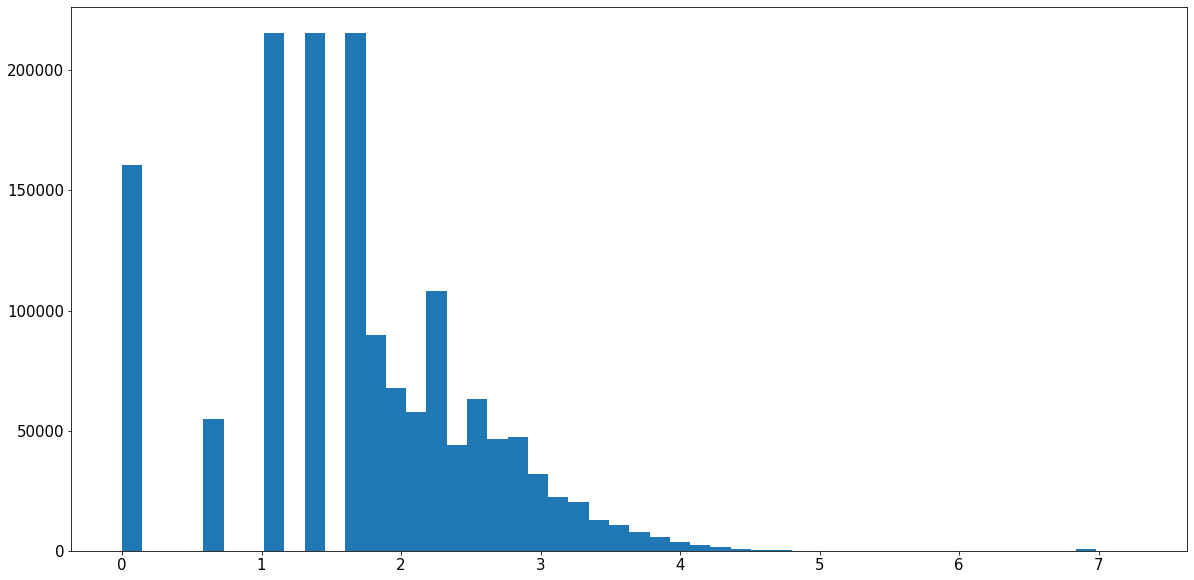

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
labels=range(0,7)
trainview_df['bin'] = pd.qcut(trainview_df['status_transformed'], q=10, duplicates = 'drop', labels = labels)
trainview_df['bin'] = trainview_df['bin'].astype('category')
trainview_df.dtypes
rus = RandomUnderSampler()
trainview_rus, status_rus = rus.fit_resample(trainview_df.drop(['bin'], axis = 1), trainview_df['bin'])
trainview_rus = pd.DataFrame(trainview_rus, columns =  trainview_df.columns[:-1])
plt.figure(figsize=(20,10))
plt.hist(x=trainview_rus['status_transformed'], bins = 50)
plt.show()

To make prediction with this resampled data, I had to read it into Spark. I then proceeded to one hot encode the categorical features,  assemble the features, and split the data into testing and training sets in the same way I had previously done. 

In [ ]:
trainview_rus_copy = trainview_rus.copy()
trainview_rus_copy = trainview_rus_copy.rename(columns = {'status_transformed':'label'}) 
trainview_rus_copy.to_csv('trainview_rus.csv')
trainview_rus_sdf = spark.read.csv('trainview_rus.csv', header = True, inferSchema= True)

from pyspark.ml.feature import StringIndexer, OneHotEncoder

stringIndexer_destination = StringIndexer(inputCol="dest", outputCol="destination_num")
stringIndexer_service = StringIndexer(inputCol="service", outputCol="service_num")
stringIndexer_next_station = StringIndexer(inputCol="next_station", outputCol="next_station_num")
stringIndexer_source = StringIndexer(inputCol="source", outputCol="source_num")

model_destination = stringIndexer_destination.fit(trainview_rus_sdf)
trainview_rus_sdf = model_destination.transform(trainview_rus_sdf)
model_service = stringIndexer_service.fit(trainview_rus_sdf)
trainview_rus_sdf = model_service.transform(trainview_rus_sdf)
model_next_station = stringIndexer_next_station.fit(trainview_rus_sdf)
trainview_rus_sdf = model_next_station.transform(trainview_rus_sdf)
model_source = stringIndexer_source.fit(trainview_rus_sdf)
trainview_rus_sdf = model_source.transform(trainview_rus_sdf)
trainview_rus_sdf = trainview_rus_sdf.drop('dest', 'service', 'next_station', 'source')

encoder_destination = OneHotEncoder(dropLast=False, inputCol="destination_num", outputCol="destination_encoded")
trainview_rus_sdf = encoder_destination.transform(trainview_rus_sdf)
encoder_service = OneHotEncoder(dropLast=False, inputCol="service_num", outputCol="service_encoded")
trainview_rus_sdf = encoder_service.transform(trainview_rus_sdf)
encoder_next_station = OneHotEncoder(dropLast=False, inputCol="next_station_num", outputCol="next_station_encoded")
trainview_rus_sdf = encoder_next_station.transform(trainview_rus_sdf)
encoder_source = OneHotEncoder(dropLast=False, inputCol="source_num", outputCol="source_encoded")
trainview_rus_sdf = encoder_source.transform(trainview_rus_sdf)
trainview_rus_sdf = trainview_rus_sdf.drop('destination_num', 'service_num', 'next_station_num', 'source_num')

from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(inputCols=['lon', 'lat', 'seconds', 'month', 'weekday','hour', 'minute', 'problem', \
                                       'destination_encoded', 'service_encoded', 'next_station_encoded', 'source_encoded'], outputCol='features')

trainview_rus_sdf_transformed = assembler.transform(trainview_rus_sdf)

temp_train_rus_sdf, test_rus_sdf = trainview_rus_sdf_transformed.randomSplit([0.8, 0.2], seed = 1)
train_rus_sdf, validation_rus_sdf = temp_train_rus_sdf.randomSplit([0.9, 0.1], seed = 1)

Next, I ran another linear regression model on the resampled data. As the output below shows, the testing RMSE of this model (0.83) is lower than that of the linear regression model without resampling (0.95).

In [ ]:
from pyspark.ml.feature import StandardScaler
from pyspark.ml.regression import LinearRegression
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator

scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures")
lr = LinearRegression(featuresCol='scaledFeatures')
pipeline = Pipeline(stages=[scaler, lr])
lr_model = pipeline.fit(trainview_rus_sdf_transformed)
lr_predictions = lr_model.transform(test_rus_sdf)
re = RegressionEvaluator(metricName='rmse')

print("RMSE: " + str(re.evaluate(lr_predictions)))
print("R2: " + str(lr_model.stages[-1].summary.r2))

RMSE: 0.8266009086413271
R2: 0.1356512104856582


The distributions of the testing predictions and testing labels now appear to be more similar using the resampled data. 

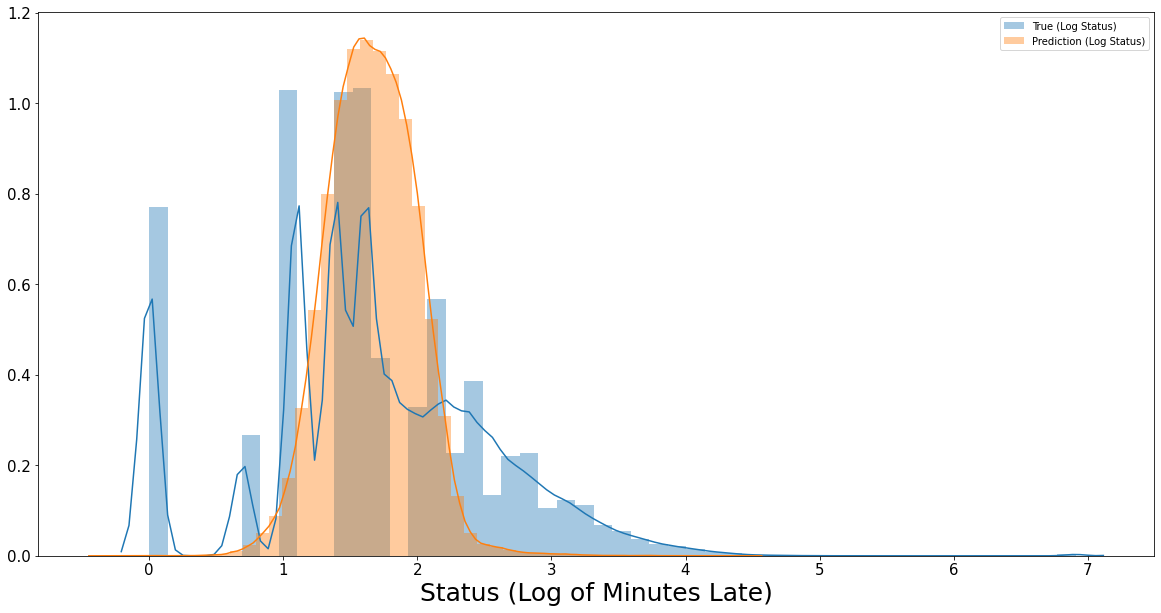

In [ ]:
lr_predictions.createOrReplaceTempView('lr_predictions')
lr_label_pred = spark.sql('SELECT label, prediction FROM lr_predictions').toPandas()
plt.figure(figsize=(20,10))
sns.distplot(lr_label_pred['label'])
sns.distplot(lr_label_pred['prediction'])
plt.xlabel('Status (Log of Minutes Late)', fontsize=25)
ax = plt.gca()
ax.legend(['True (Log Status)', 'Prediction (Log Status)'])
plt.show()

# Random Forest Regression
Next, I ran a random forest regression model. This model is an ensemble of many regression trees. Because random forrests combine many individual regression trees, they reduce the risk of overfitting the training data compared to a single or few regression trees. I ran a random forest models where the maximum depths of the trees are 2, 4, 6, 8, and 10 in order to find the optimal depth. Shallower trees may not capture enough signficant relations in the data, but deep trees risk overfitting the training data. Note that data does not need to be scaled before using a random forest model. I then evaluated the performance of these models on the validation data to tune the maxDepth parameter. As the validation RMSE's below show, RMSE decreases as tree depth increases here. Unfortunately, with an ensemble method like random forest we cannot interpret what features were important to predicting a train's status like I did with the linear regression model.

In [ ]:
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator

rf2 = RandomForestRegressor(maxDepth = 2)
rf_model2 = rf2.fit(train_sdf)
rf_predictions2 = rf_model2.transform(validation_sdf)

rf4 = RandomForestRegressor(maxDepth = 4)
rf_model4 = rf4.fit(train_sdf)
rf_predictions4 = rf_model4.transform(validation_sdf)

rf6 = RandomForestRegressor(maxDepth = 6)
rf_model6 = rf6.fit(train_sdf)
rf_predictions6 = rf_model6.transform(validation_sdf)

rf8 = RandomForestRegressor(maxDepth = 8)
rf_model8 = rf8.fit(train_sdf)
rf_predictions8 = rf_model8.transform(validation_sdf)

rf10 = RandomForestRegressor(maxDepth = 10)
rf_model10 = rf10.fit(train_sdf)
rf_predictions10 = rf_model10.transform(validation_sdf)

re = RegressionEvaluator(metricName='rmse')

print("Max Depth 2")
print("Validation RMSE: " + str(re.evaluate(rf_predictions2)))
print("Max Depth 4")
print("Validation RMSE: " + str(re.evaluate(rf_predictions4)))
print("Max Depth 6")
print("Validation RMSE: " + str(re.evaluate(rf_predictions6)))
print("Max Depth 8")
print("Validation RMSE: " + str(re.evaluate(rf_predictions8)))
print("Max Depth 10")
print("Validation RMSE: " + str(re.evaluate(rf_predictions10)))

Max Depth 2
Validation RMSE: 0.9952084667459439
Max Depth 4
Validation RMSE: 0.9656726619593654
Max Depth 6
Validation RMSE: 0.9427475416332012
Max Depth 8
Validation RMSE: 0.9186373792352664
Max Depth 10
Validation RMSE: 0.8915921854319534


Next, we can look at how well each of these random forest prediction fits the validation data by looking at the distributions of the true values and predictions. We can see that as the tree depth increases, the distribution of the predictions nears the data's true distributions as large spikes in the data are reduced. Note that none of the random forest predictions capture the large prevelance of statuses of 0. 

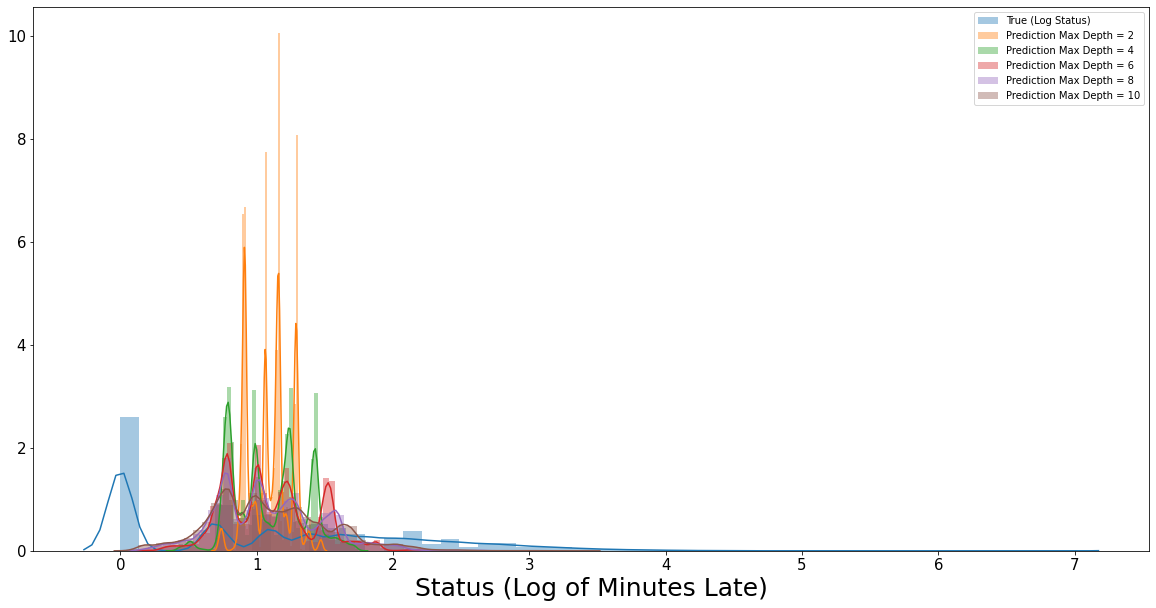

In [ ]:
rf_predictions2.createOrReplaceTempView('rf_predictions2')
rf_label_pred2 = spark.sql('SELECT label, prediction FROM rf_predictions2').toPandas()
rf_predictions4.createOrReplaceTempView('rf_predictions4')
rf_label_pred4 = spark.sql('SELECT label, prediction FROM rf_predictions4').toPandas()
rf_predictions6.createOrReplaceTempView('rf_predictions6')
rf_label_pred6 = spark.sql('SELECT label, prediction FROM rf_predictions6').toPandas()
rf_predictions8.createOrReplaceTempView('rf_predictions8')
rf_label_pred8 = spark.sql('SELECT label, prediction FROM rf_predictions8').toPandas()
rf_predictions10.createOrReplaceTempView('rf_predictions10')
rf_label_pred10 = spark.sql('SELECT label, prediction FROM rf_predictions10').toPandas()

plt.figure(figsize=(20,10))
sns.distplot(rf_label_pred2['label'])
sns.distplot(rf_label_pred2['prediction'])
sns.distplot(rf_label_pred4['prediction'])
sns.distplot(rf_label_pred6['prediction'])
sns.distplot(rf_label_pred8['prediction'])
sns.distplot(rf_label_pred10['prediction'])
plt.xlabel('Status (Log of Minutes Late)', fontsize=25)
ax = plt.gca()
ax.legend(['True (Log Status)', 'Prediction Max Depth = 2', 'Prediction Max Depth = 4', \
           'Prediction Max Depth = 6', 'Prediction Max Depth = 8', 'Prediction Max Depth = 10'])
plt.show()

Because of the random forest model's inability to capture the statuses of 0, I decided to run the same random forest models on the resampled data, which had a lower prevelance of 0 statuses. As the results below indicate, for each depth of the the decision tree, the random forest regressor performs better on the resampled data compared to the original data. 

In [ ]:
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator

rf2 = RandomForestRegressor(maxDepth = 2)
rf_model2 = rf2.fit(temp_train_rus_sdf)
rf_predictions2 = rf_model2.transform(validation_rus_sdf)

rf4 = RandomForestRegressor(maxDepth = 4)
rf_model4 = rf4.fit(temp_train_rus_sdf)
rf_predictions4 = rf_model4.transform(validation_rus_sdf)

rf6 = RandomForestRegressor(maxDepth = 6)
rf_model6 = rf6.fit(temp_train_rus_sdf)
rf_predictions6 = rf_model6.transform(validation_rus_sdf)

rf8 = RandomForestRegressor(maxDepth = 8)
rf_model8 = rf8.fit(temp_train_rus_sdf)
rf_predictions8 = rf_model8.transform(validation_rus_sdf)

rf10 = RandomForestRegressor(maxDepth = 10)
rf_model10 = rf10.fit(temp_train_rus_sdf)
rf_predictions10 = rf_model10.transform(validation_rus_sdf)

re = RegressionEvaluator(metricName='rmse')

print("Max Depth 2")
print("Validation RMSE: " + str(re.evaluate(rf_predictions2)))
print("Max Depth 4")
print("Validation RMSE: " + str(re.evaluate(rf_predictions4)))
print("Max Depth 6")
print("Validation RMSE: " + str(re.evaluate(rf_predictions6)))
print("Max Depth 8")
print("Validation RMSE: " + str(re.evaluate(rf_predictions8)))
print("Max Depth 10")
print("Validation RMSE: " + str(re.evaluate(rf_predictions10)))

Max Depth 2
Validation RMSE: 0.8535071723630762
Max Depth 4
Validation RMSE: 0.8341865102822325
Max Depth 6
Validation RMSE: 0.8187576339752605
Max Depth 8
Validation RMSE: 0.8024778035700604
Max Depth 10
Validation RMSE: 0.7818640844118263


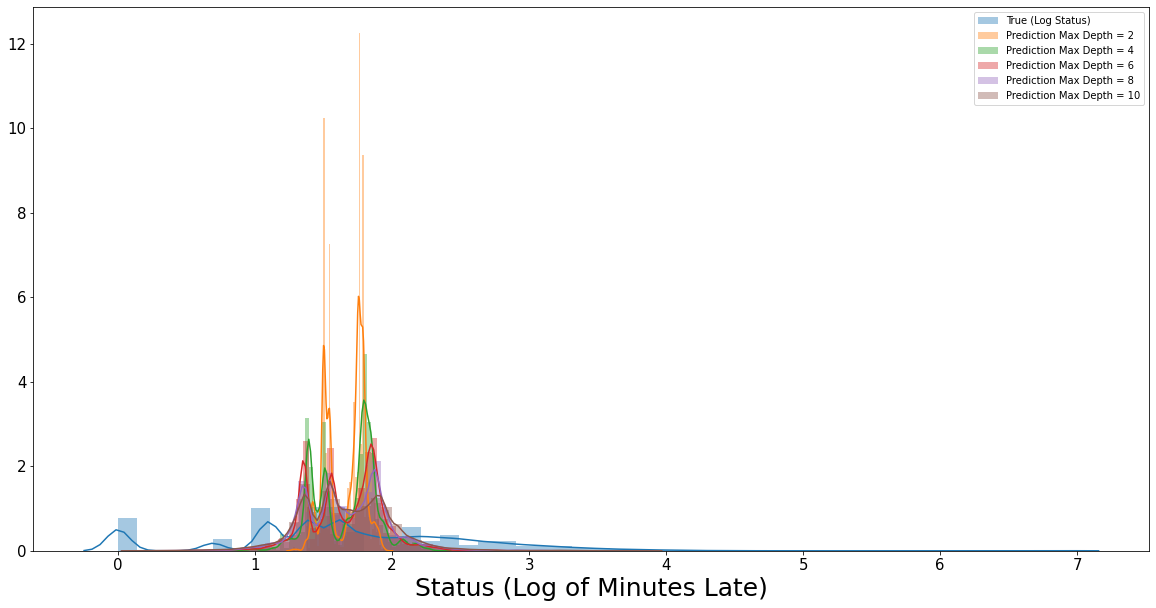

In [ ]:
rf_predictions2.createOrReplaceTempView('rf_predictions2')
rf_label_pred2 = spark.sql('SELECT label, prediction FROM rf_predictions2').toPandas()
rf_predictions4.createOrReplaceTempView('rf_predictions4')
rf_label_pred4 = spark.sql('SELECT label, prediction FROM rf_predictions4').toPandas()
rf_predictions6.createOrReplaceTempView('rf_predictions6')
rf_label_pred6 = spark.sql('SELECT label, prediction FROM rf_predictions6').toPandas()
rf_predictions8.createOrReplaceTempView('rf_predictions8')
rf_label_pred8 = spark.sql('SELECT label, prediction FROM rf_predictions8').toPandas()
rf_predictions10.createOrReplaceTempView('rf_predictions10')
rf_label_pred10 = spark.sql('SELECT label, prediction FROM rf_predictions10').toPandas()

plt.figure(figsize=(20,10))
sns.distplot(rf_label_pred2['label'])
sns.distplot(rf_label_pred2['prediction'])
sns.distplot(rf_label_pred4['prediction'])
sns.distplot(rf_label_pred6['prediction'])
sns.distplot(rf_label_pred8['prediction'])
sns.distplot(rf_label_pred10['prediction'])
plt.xlabel('Status (Log of Minutes Late)', fontsize=25)
ax = plt.gca()
ax.legend(['True (Log Status)', 'Prediction Max Depth = 2', 'Prediction Max Depth = 4', \
           'Prediction Max Depth = 6', 'Prediction Max Depth = 8', 'Prediction Max Depth = 10'])
plt.show()

Finally, I selected the the random forest regression with a max depth of 10 trained on the resampled data as the final regression model due to its low validation RMSE. I then evaluated how this model performed on the test data. This model acheived a testing RMSE of 0.785 (units: log(status)).

In [ ]:
rf_test_predictions10 = rf_model10.transform(test_rus_sdf)
print("Max Depth 10")
print("Test RMSE: " + str(re.evaluate(rf_test_predictions10)))

Max Depth 10
Test RMSE: 0.785461069703696


# Description of Challenges
I faced several challenges throughout this project. The largest challenge I faced was working with a highly skewed response variable. Because so many of the train's statuses were 0, I needed to find a way to transform the data. I first tried out a square root transformation, but found that this tansformation was not strong enough to substantially reduce the skewness of the data. I ultimately settled on a log transformation. However, even with the log transformation, the data was highly skewed and trains with a status of 0 were highly prevelant. It wasn't until I started building my models that I realized the high prevelance of statuses of 0 would adversely impact my models' performances. As a result, I decided to downsample observations corresponding to a status of 0. This approach proved effective in improving my models' performances. I tried downsampling based on the original status and log transformed status and found that performance was better when working with the transformed variable. Before settling on this approach, there were several alternatives I considered. I thought about transforming status to an ordinal feature, which is similar to a categorical variable but there is ordering of the categories. I could not have treated status as a categorical variable because of the clear ordering of groups. I played around with ordinal regression, but this model is not well defined in Spark and the size of my data made me hesitant about implementing this model in Pandas. Ultimately, I think that the combination of a log transformation and resampling reduced enough of the data's skewness.  

Another challenge I faced was the large number of categorical features in the data. For these features to be useful for creating ML models, I knew I would somehow need to transform them into numeric variables. However, transforming these features into numeric ones increased the number of features in the model from 12 to 482, which was a very dramatic increase. Because of the large number of features the data now contained, I had to switch from working in Pandas to Spark. This challenge was unexpected and was definitely a setback for me as I had previously started building models with SK Learn. Switching to Spark meant I had to implement the models I had already began working on again. Spark also proved to be challenging in encoding categorical features with a one hot encoding. While a one hot encoding in Pandas uses one line of code with the get_dummies function, a one hot encoding in Spark is not as simple. Looking through the documenation for StringIndexers and OneHotEncoders was tedious and challenging. 

# Conclusion and Next Steps
Overall, I was able to predict a train's status, how many minutes late it was running, using the Septa dataset provided by Kaggle. Exploring the data, I found that status was highly right skewed, which motivated me to use a log transformation. I also observed the status was influenced by the month, time of day, day of week, and whether a problem was indicated along a train's route. Next, before creating any models, I read the data into Spark, one hot encoded categorical features, and split the data into training, validation, and testing sets. 

I then created a linear regression model. I observed that this model did not accurately capture the distribution of the status feature. I also analyzed some of the linear model coefficients, finding that train performance was worse at higher longitudes and later months and performance was better at higher latitudes. Status was also heavily influenced by several origin and destination stations. I decided to perfrom L1 normalization due to the small number of signficant coefficients. The regularized linear model performed comparably to the linear model without regularization. I then downsampled statuses of 0 and ran an ordinary linear regression model, which performed better than the original linear regression model.  

Next, I created a random forest model. I varied the maximum depth of the trees in the model between 2, 4, 6, 8, and 10. I observed that RMSE on the validation set decreased as depth increased. I then ran the same analysis on the resampled data. I found that the random forest model trained on the resampled data consistently performed better than the model trained on the original data. 

Overall, the model that achieved the lowest RMSE was the random forest model with max depth 10 trained on the resampled data. The RMSE of this model was 0.785 log(minutes) or 2.19 minutes. The analysis performed indicates that Septa train status can be accurately predicted from geographical and temporal information about Septa trains. 

The models I created in this project could be improved in several ways. A dataset containing more observations where the train's status was not 0 would be useful in creating better models. Other model types like a neural network could probably be explored. This project could also be extended to make real time predictions on the status of Septa trains. Real time predictions would provide commuters with accurate data as they are in the midst of deciding which train to take.

Lastly, This project suggests that rather than providing commuters with the OTP metric averaged across all trains, Septa could better serve its customers by offering a measure of reliability for specific trains. Septa should report predictions for train's status to its customers. Further, Septa should break down how its trains perform in terms of OTP throughout different times of the day, days of the week, and different stations. By doing so, Septa could see how busy commuter times and the winter season hinders its perfromance. In doing so, Septa could enforce a set of regulations aimed to keep trains running on time when they are busy or when adverse weather hits. Septa could also see how trains originating from some stations perform better than others and adopt practices from better performing stations to all of its stations. 